# Grocery Object Detection Model

Objective: train a simple object detection model to identify instances of products in a given image. This notebook will attempt to locate and
classify occurrences of different products in supermarket shelves using a subset of the Grozi-3.2K dataset.

In [5]:
#initial parameters
dir_to_project = '/content/drive/Shareddrives/Code Challenges/Memorable' #@param {type: "string"}
dir_to_repo = '/content/yolov5'


In [6]:
#Mount google drive in order to get the data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
#reset the status of the annotations folder to before
import os

!rm dir_to_project+'/grozi_coco/annotations/instances_train2017.json'
!rm dir_to_project+'/grozi_coco/annotations/instances_val2017.json'

#delete cache of the training/validation
!rm dir_to_project+'/grozi_coco/labels/train2017.cache'
!rm dir_to_project+'/grozi_coco/labels/val2017.cache'


#!rmdir dir_to_project+'/grozi_coco/labels/' --ignore-fail-on-non-empty

# Absolute path of a file
old_name_train = dir_to_project+'/grozi_coco/annotations/old_instances_train2017.json'
new_name_train = dir_to_project+'/grozi_coco/annotations/instances_train2017.json'

old_name_val = dir_to_project+'/grozi_coco/annotations/old_instances_val2017.json'
new_name_val = dir_to_project+'/grozi_coco/annotations/instances_val2017.json'


# Renaming the file
try:
  os.rename(old_name_train, new_name_train)
  os.rename(old_name_val, new_name_val)
except:
  print('There was no older version of the annotations!')

rm: cannot remove 'dir_to_project+/grozi_coco/annotations/instances_train2017.json': No such file or directory
rm: cannot remove 'dir_to_project+/grozi_coco/annotations/instances_val2017.json': No such file or directory
rm: cannot remove 'dir_to_project+/grozi_coco/labels/train2017.cache': No such file or directory
rm: cannot remove 'dir_to_project+/grozi_coco/labels/val2017.cache': No such file or directory


In [8]:
#clone YOLOv5 and 

!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
%pip install -qr requirements.txt # install dependencies

Cloning into 'yolov5'...
remote: Enumerating objects: 12327, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 12327 (delta 4), reused 10 (delta 4), pack-reused 12316
Receiving objects: 100% (12327/12327), 11.52 MiB | 13.96 MiB/s, done.
Resolving deltas: 100% (8561/8561), done.
/content/yolov5
     |████████████████████████████████| 596 kB 4.5 MB/s 


In [9]:
import torch
torch.cuda.empty_cache()
from IPython.display import Image, clear_output  # to display images

print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Setup complete. Using torch 1.10.0+cu111 (CPU)


#Exploration of Dataset

### COCO API (pyCoco)

In [10]:
#https://github.com/cocodataset/cocoapi/blob/master/PythonAPI/pycocoDemo.ipynb

In [11]:
#import libraries
%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (8.0, 10.0)

In [12]:
#get the file path to the train dataset (both images and their annotations)
dataDir=dir_to_project+'/grozi_coco'
dataType=['train2017','val2017']
train_images_dir = dataDir+'/'+dataType[0]
annFile='{}/annotations/instances_{}.json'.format(dataDir,dataType[0])

In [13]:
annFile

'/content/drive/Shareddrives/Code Challenges/Memorable/grozi_coco/annotations/instances_train2017.json'

In [14]:
# initialize COCO api for instance annotations
coco=COCO(annFile)

loading annotations into memory...
Done (t=0.06s)
creating index...
index created!


In [15]:
# display COCO categories and supercategories
cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]
print('COCO categories: \n{}\n'.format(' '.join(nms)))

nms = set([cat['supercategory'] for cat in cats])
print('COCO supercategories: \n{}'.format(' '.join(nms)))

COCO categories: 
0.jpg 1.jpg 2.jpg 3.jpg 4.jpg 5.jpg 6.jpg 7.jpg 8.jpg 9.jpg 10.jpg 11.jpg 413.jpg 13.jpg 14.jpg 15.jpg 16.jpg 17.jpg 18.jpg 19.jpg 20.jpg 21.jpg 1001.jpg 22.jpg 23.jpg 28.jpg 29.jpg 26.jpg 27.jpg 31.jpg 32.jpg 33.jpg 1221.jpg 35.jpg 36.jpg 37.jpg 34.jpg 38.jpg 39.jpg 1218.jpg 41.jpg 42.jpg 43.jpg 44.jpg 45.jpg 46.jpg 54.jpg 47.jpg 48.jpg 49.jpg 50.jpg 56.jpg 52.jpg 53.jpg 55.jpg 51.jpg 57.jpg 58.jpg 59.jpg 60.jpg 61.jpg 62.jpg 63.jpg 67.jpg 68.jpg 69.jpg 70.jpg 71.jpg 72.jpg 73.jpg 74.jpg 75.jpg 76.jpg 77.jpg 78.jpg 79.jpg 599.jpg 81.jpg 601.jpg 83.jpg 89.jpg 90.jpg 91.jpg 1007.jpg 93.jpg 1008.jpg 95.jpg 96.jpg 97.jpg 98.jpg 99.jpg 100.jpg 101.jpg 92.jpg 102.jpg 103.jpg 104.jpg 1009.jpg 106.jpg 107.jpg 94.jpg 108.jpg 109.jpg 110.jpg 111.jpg 1010.jpg 113.jpg 114.jpg 115.jpg 112.jpg 116.jpg 117.jpg 105.jpg 120.jpg 121.jpg 122.jpg 125.jpg 126.jpg 127.jpg 128.jpg 129.jpg 130.jpg 131.jpg 123.jpg 132.jpg 133.jpg 1011.jpg 136.jpg 137.jpg 139.jpg 140.jpg 141.jpg 142.jpg 143.j

it seems that the categories are the names of the pictures and that no classes for the objects were uploaded when labeling the data

In [16]:
#image to see the annotations
image_name = '0.jpg'
image_id = 0

In [17]:
coco.getCatIds(catNms=[image_name])

[0]

In [18]:
coco.getImgIds(catIds=[0])

[0, 1, 229, 230, 343, 344, 345, 346, 219, 220]

In [19]:
#Load the json files of the annotations
import json
import pandas as pd
from pandas.io.json import json_normalize


with open(dir_to_project+'/grozi_coco/annotations/instances_train2017.json') as json_file:
    data = json.load(json_file)
    #dump the json file to see the structure
    data_dump = json.dumps(data, indent=4)


annotations_df = json_normalize(data)
annotations_df = annotations_df.explode('annotations')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  del sys.path[0]


In [20]:
annotations_df

images       type  \
0   [{'file_name': '0.jpg', 'height': 2448, 'width...  instances   
0   [{'file_name': '0.jpg', 'height': 2448, 'width...  instances   
0   [{'file_name': '0.jpg', 'height': 2448, 'width...  instances   
0   [{'file_name': '0.jpg', 'height': 2448, 'width...  instances   
0   [{'file_name': '0.jpg', 'height': 2448, 'width...  instances   
..                                                ...        ...   
0   [{'file_name': '0.jpg', 'height': 2448, 'width...  instances   
0   [{'file_name': '0.jpg', 'height': 2448, 'width...  instances   
0   [{'file_name': '0.jpg', 'height': 2448, 'width...  instances   
0   [{'file_name': '0.jpg', 'height': 2448, 'width...  instances   
0   [{'file_name': '0.jpg', 'height': 2448, 'width...  instances   

                                          annotations  \
0   {'area': 248115, 'iscrowd': 0, 'bbox': [350, 0...   
0   {'area': 284580, 'iscrowd': 0, 'bbox': [767, 0...   
0   {'area': 287532, 'iscrowd': 0, 'bbox': [1272, ...   
0   {'area': 259488, 'iscrowd': 0, 'bbox': [1697, ...   
0   {'area': 217005, 'iscrowd': 0, 'bbox': [2105, ...   
..                                                ...   
0   {'area': 181560, 'iscrowd': 0, 'bbox': [489, 1...   
0   {'area': 264110, 'iscrowd': 0, 'bbox': [24, 14...   
0   {'area': 478290, 'iscrowd': 0, 'bbox': [1260, ...   
0   {'area': 540800, 'iscrowd': 0, 'bbox': [1052, ...   
0   {'area': 663936, 'iscrowd': 0, 'bbox': [94, 4,...   

                                           categories  
0   [{'supercategory': 'none', 'id': 0, 'name': '0...  
0   [{'supercategory': 'none', 'id': 0, 'name': '0...  
0   [{'supercategory': 'none', 'id': 0, 'name': '0...  
0   [{'supercategory': 'none', 'id': 0, 'name': '0...  
0   [{'supercategory': 'none', 'id': 0, 'name': '0...  
..                                                ...  
0   [{'supercategory': 'none', 'id': 0, 'name': '0...  
0   [{'supercategory': 'none', 'id': 0, 'name': '0...  
0   [{'supercategory': 'none', 'id': 0, 'name': '0...  
0   [{'supercategory': 'none', 'id': 0, 'name': '0...  
0   [{'supercategory': 'none', 'id': 0, 'name': '0...  

[7781 rows x 4 columns]

Actual example of the output of annotations section: 

```
"annotations": [
        {
            "area": 248115,
            "iscrowd": 0,
            "bbox": [
                350,
                0,
                417,
                595
            ],
            "category_id": 0,
            "ignore": 0,
            "segmentation": [],
            "image_id": 0,
            "id": 0
        },

```



The annotations section:


- Contains list of each individual object annotation from every single image in the dataset. This is the section that contains the bounding box output or object segmentation for object detection

- If an image has 4 objects that we want to detect then we will have annotations for all 4 objects.

- segmentation contains the x and y coordinates for the vertices of the polygon around every object instance for the segmentation masks.

- area is the area of the bounding box. It is a pixel value

- iscrowd: If we have a single object segmentation then iscrowd is set to zero. For a collection of objects present in the image, we set iscrowd=1

- imageid: It is the id of the image which contains the objects for which we are specifying the annotations . The imageid corresponds to the imageid that we have in the image section

- bbox : Bounding box in COCO is the x and y co-ordinate of the top left and the height and width. 
- COCO Bounding box: (x-top left, y-top left, width, height)

- id: It is the unique id for the annotations


Explore the categories of the dataset

In [21]:
#get all categories given image id
def GetCategoriesFromImageId(image_id):
    categories = []
    for annotation in data['annotations']:
        if annotation['image_id'] == image_id:
            categories.append(annotation['category_id'])
    return categories

In [22]:
#get all the categories of annotations that are in the image with an id = 0
cat_examples_0 = GetCategoriesFromImageId(0)

In [23]:
# get all images containing given categories, select one at random
catIds = coco.getCatIds(catIds=cat_examples_0);
imgIds = coco.getImgIds(catIds=catIds );

#get random image (10 for example)
imgIds = coco.getImgIds(imgIds = [image_id])
img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]

In [24]:
print(imgIds)
print(catIds)

[0]
[0, 1, 2, 3, 4, 5, 6, 7, 1055]


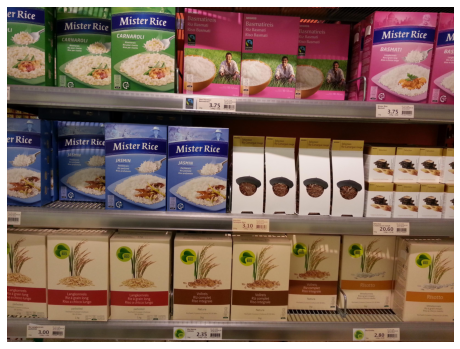

In [25]:
# load and display image
I = io.imread('%s/images/%s/%s'%(dataDir,dataType[0],img['file_name']))
# use url to load image
#I = io.imread(img['coco_url'])
plt.axis('off')
plt.imshow(I)
plt.show()

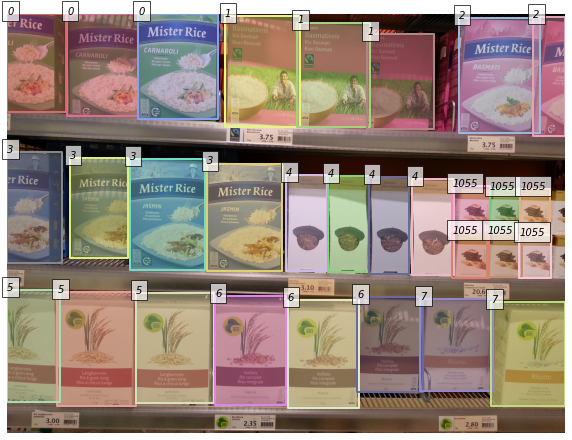

In [26]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(I);plt.axis('off')

annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
anns = coco.loadAnns(annIds)

coco.showAnns(anns, draw_bbox=True)
for i, ann in enumerate(anns):
    ax.text(anns[i]['bbox'][0], anns[i]['bbox'][1], anns[i]['category_id'], style='italic', 
            bbox={'facecolor': 'white', 'alpha': 0.7, 'pad': 5})

In [27]:
#get the number of classes in the training dataset

def getAllCategoriesFromAnnotations(annotations_filepath,type):
  
  #load the annotations into a variable
  with open(annotations_filepath) as json_file:
    data = json.load(json_file)

  #append the categories to a list
  categories_ids = []
  categories_names = []


  #loop over the ids in the categories section of the annotations 
  for category in data['categories']:
        categories_ids.append(category['id'])
        categories_names.append(category['name'])

   
  print(f' The amount of ({type})categories/classes is: {len(categories_ids)}','\n')
  
  return list(zip(categories_ids,categories_names)),categories_names
  

In [28]:
#output: category_id, category_name
training_classes = getAllCategoriesFromAnnotations(dir_to_project+'/grozi_coco/annotations/instances_train2017.json','train')

number_of_classes = len(training_classes)


 The amount of (train)categories/classes is: 878 



# Algorithm selection

Basically there are two important drivers to analyze when selecting a model for object detection: 

- Accuracy
- Speed of implementation (FPS)

The speed of implementation has a lot of weight when selecting the model but the accuracy must reach a minimun required level as it is of no use a model that can not detect well. 

Ultralytics have done a terrific job with the development of YOLOv5 that accomplishes great balance between speed and accuracy in comparison to its model brothers (Cochard, 2021): 

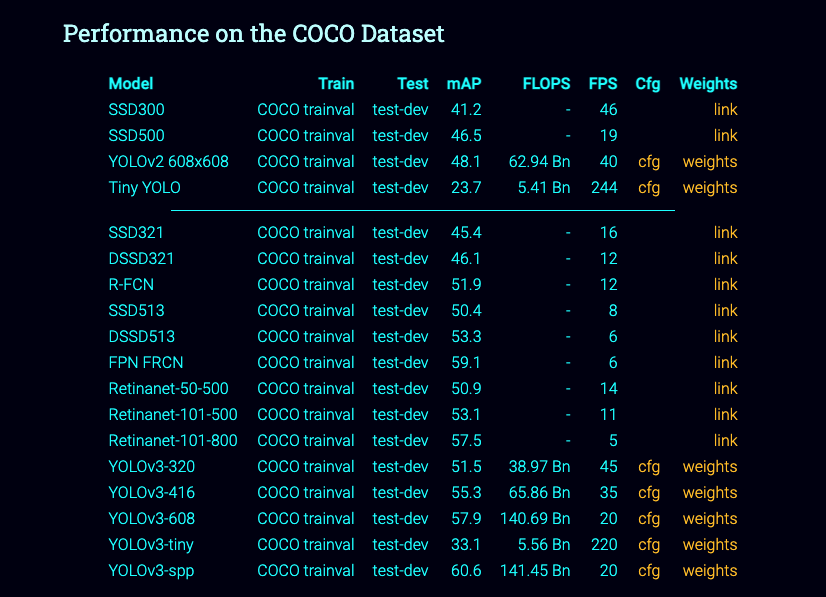


YOLOv5 s achieves the same accuracy as YOLOv3-416 with about 1/4 of the computational complexity. (Cochard, 2021)

#YOLOv5 Overview

How YOLO works is that we take an image and split it into an SxS grid, within each of the grid we take m bounding boxes. For each of the bounding box, the network outputs a class probability and offset values for the bounding box. The bounding boxes having the class probability above a threshold value is selected and used to locate the object within the image.

YOLO is orders of magnitude faster(45 frames per second) than other object detection algorithms. The limitation of YOLO algorithm is that it struggles with small objects within the image, for example it might have difficulties in detecting a flock of birds. This is due to the spatial constraints of the algorithm (Gandhi, 2018). 

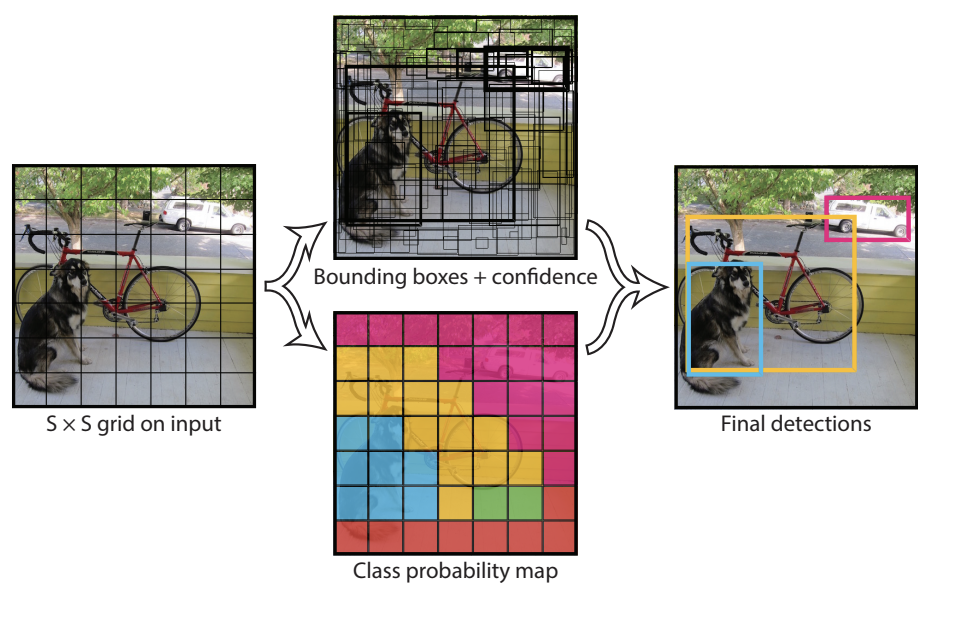

#### YOLOv5 Family

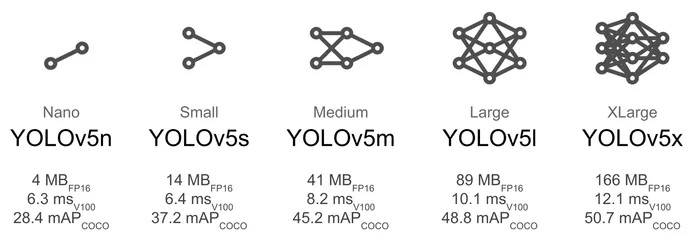

YOLOv5 🚀 is a family of compound-scaled object detection models trained on the COCO dataset, and includes simple functionality for Test Time Augmentation (TTA), model ensembling, hyperparameter evolution, etc.

YOLOv5 has multiple varieties of pre-trained models as we can see above. The difference between them is the trade-off between the size of the model and inference time.

#### YOLOv5 Architecture

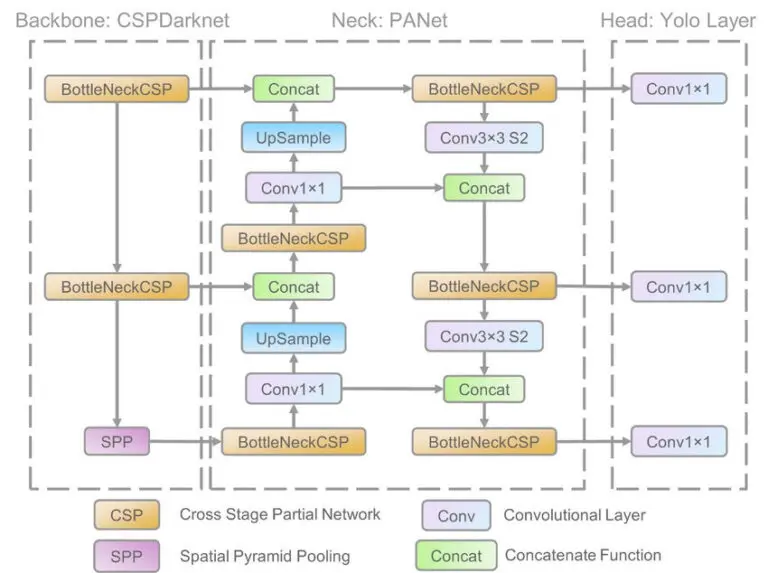

The YOLO family of models consists of three main architectural blocks i) Backbone, ii) Neck and iii) Head (Maindola, 2022).

- YOLOv5 Backbone: It employs CSPDarknet as the backbone for feature extraction from images consisting of cross-stage partial networks.
- YOLOv5 Neck: It uses PANet to generate a feature pyramids network to perform aggregation on the features and pass it to Head for prediction.
- YOLOv5 Head:  Layers that generate predictions from the anchor boxes for object detection.

Apart from this YOLOv5 uses the below choices for training:

- Activation and Optimization: YOLOv5 uses leaky ReLU and sigmoid activation, and SGD and ADAM as optimizer options.
- Loss Function: It uses Binary cross-entropy with logits loss.

# Data Handling



### Relabeling the classes ids

When trying to use the model for training, an error will be raised regarding number of classes. 

The number of classes must be of exact match to the index number of the classes. For example, there are 878 classes but there is an id with number 1055, so an error is raised. The id number of any category muss be less or equal to number of classes (nc). 

We will reindex the ids in the categories section of the annotations and afterwards in the annotations section and save everything into a new json file.

In [29]:
#make a copy of the annotations object for trials
#annotations_copy = data.copy()

with open(dir_to_project+'/grozi_coco/annotations/instances_train2017.json') as json_train_file:
    annotations_train_copy = json.load(json_train_file)

with open(dir_to_project+'/grozi_coco/annotations/instances_val2017.json') as json_val_file:
    annotations_val_copy = json.load(json_val_file)

In [30]:
ann_files = ['train','val']
vars()['train'] = annotations_train_copy
vars()['val'] = annotations_val_copy

In [31]:
vars()['train']['categories'][12]

{'id': 413, 'name': '413.jpg', 'supercategory': 'none'}

In [32]:
#change the category ids so that the index is the category id
index = 0
replacement_dict = {}

for ann in ann_files:
  for category in vars()[ann]['categories']: #annotations_train_copy['categories']:
    #save the replacement into a dict so it can be used later for the annotations section
    replacement_dict[category['id']] = index
    #replace the id 
    category['id'] = index

    index += 1
      

In [33]:
#checking the result of replacement in the categories section of the annotation
vars()['train']['categories'][12] #id = 12 >> proof of the change because before it would have been id = 413, name = 413.jpg

{'id': 12, 'name': '413.jpg', 'supercategory': 'none'}

In [34]:
#use the category_id 64 to check the new index relabeling
for annotation in vars()['train']['annotations']: #annotations_train_copy['annotations']:

  if annotation['category_id'] == 64:
    print(annotation)

{'area': 1671318, 'iscrowd': 0, 'bbox': [0, 1729, 1101, 1518], 'category_id': 64, 'ignore': 0, 'segmentation': [], 'image_id': 115, 'id': 1359}
{'area': 723713, 'iscrowd': 0, 'bbox': [0, 1991, 677, 1069], 'category_id': 64, 'ignore': 0, 'segmentation': [], 'image_id': 116, 'id': 1367}
{'area': 896112, 'iscrowd': 0, 'bbox': [1664, 2121, 784, 1143], 'category_id': 64, 'ignore': 0, 'segmentation': [], 'image_id': 117, 'id': 1375}


In [35]:
print(f'The new id for the category_id = 64 is {replacement_dict[64]}')

The new id for the category_id = 64 is 199


In [36]:
#change the category ids in the annotations section according to the replacement dict
for ann in ann_files:
  for annotation in vars()[ann]['annotations']: #annotations_train_copy['annotations']:
    annotation['category_id'] = replacement_dict[annotation['category_id']]

In [37]:
#checking if the change was made
for annotation in vars()['train']['annotations']: #annotations_train_copy['annotations']:

  if annotation['category_id'] == 199:
    print(annotation)

{'area': 1671318, 'iscrowd': 0, 'bbox': [0, 1729, 1101, 1518], 'category_id': 199, 'ignore': 0, 'segmentation': [], 'image_id': 115, 'id': 1359}
{'area': 723713, 'iscrowd': 0, 'bbox': [0, 1991, 677, 1069], 'category_id': 199, 'ignore': 0, 'segmentation': [], 'image_id': 116, 'id': 1367}
{'area': 896112, 'iscrowd': 0, 'bbox': [1664, 2121, 784, 1143], 'category_id': 199, 'ignore': 0, 'segmentation': [], 'image_id': 117, 'id': 1375}


In [38]:
ann_files

['train', 'val']

In [39]:
#check if there are already "old" annotations files created. If true, the labeling was already done and the process is skipped

old_files_path1 = os.path.isfile(dir_to_project+'/grozi_coco/annotations/old_instances_train2017.json')
old_files_path2 = os.path.isfile(dir_to_project+'/grozi_coco/annotations/old_instances_val2017.json')

if (old_files_path1 == True) and (old_files_path2 == True):
  for ann in ann_files:
    old_name = dir_to_project+'/grozi_coco/annotations/instances_'+ann+'2017.json'
    new_name = dir_to_project+'/grozi_coco/annotations/old_instances_'+ann+'2017.json'

    os.rename(old_name, new_name)

    with open(dir_to_project+'/grozi_coco/annotations/instances_'+ ann +'2017.json', 'w') as outfile:
      #json.dump(annotations_train_copy, outfile)
      json.dump(vars()[ann], outfile)
else:
  print('The process of relabeling the categories ids was already done')

The process of relabeling the categories ids was already done


After relabeling the category_ids, the object that was saving the classes names remained outdated, so we will run again the function to extract them with the new ids:

In [40]:
#output: category_id, category_name
training_classes,training_classes_names = getAllCategoriesFromAnnotations(dir_to_project+'/grozi_coco/annotations/instances_train2017.json','train')
val_classes,val_classes_names = getAllCategoriesFromAnnotations(dir_to_project+'/grozi_coco/annotations/instances_val2017.json','validation')

number_of_training_classes = len(training_classes)
number_of_val_classes = len(val_classes)

classes_names = training_classes_names + val_classes_names

number_of_classes = number_of_training_classes + number_of_val_classes

 The amount of (train)categories/classes is: 878 

 The amount of (validation)categories/classes is: 185 



In [41]:
#get the max value of the ids, to check if there is a number higher than 878
max(training_classes,key=lambda item:item[0])

(1222, '1222.jpg')

### YOLO labeling format

The YOLO labeling format, is based on one annotations text file per image. Each text file contains one bounding-box (BBox) annotation for each of the objects in the image. The annotations are normalized to the image size, and lie within the range of 0 to 1. They are represented in the following format:

`< object-class-ID> <X center> <Y center> <Box width> <Box height>`

If there are two objects in the image, the content of the YOLO annotations text file might look like this:

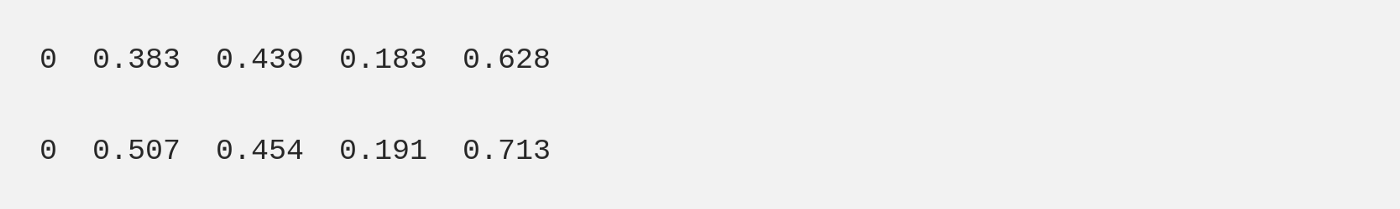



The function below will generate the labels in the necessary format for the YOLOv5 model to consume:

In [42]:
#https://github.com/qwirky-yuzu/COCO-to-YOLO/blob/main/coco_to_yolo.py

from json import JSONDecodeError
from os import path
import json
import pathlib


class ConvertCOCOToYOLO:
    """
    Takes in the path to COCO annotations and optional the path, where the YOLO annotations shall be saved
    in multiple .txt files.
    COCO annotation are to be JSON formart as follows:
        "annotations":{
            "area":2304645,
            "id":1,
            "image_id":10,
            "category_id":4,
            "bbox":[
                0::704
                1:620
                2:1401
                3:1645
            ]
        }
        
    """

    def __init__(self, json_path, label_path):
        self.json_path = json_path
        self.label_path = label_path

    def check_paths(self):
        #if self.label_path is None or not path.exists(self.label_path):
         #   self.label_path = pathlib.Path(__file__).parent.resolve()
        if self.json_path is None:
            return False
        if path.exists(self.json_path):
            try:
                json.load(open(self.json_path))
                return True
            except JSONDecodeError:
                print("cant't open Json File")
                return False
        else:
            return False

    def convert_labels(self, x1, y1, x2, y2, size):
        """
        Definition: Parses label files to extract label and bounding box
        coordinates. Converts (x1, y1, x1, y2) KITTI format to
        (x, y, width, height) normalized YOLO format.
        """

        def sorting(l1, l2):
            if l1 > l2:
                lmax, lmin = l1, l2
                return lmax, lmin
            else:
                lmax, lmin = l2, l1
                return lmax, lmin

        xmax, xmin = sorting(x1, x2)
        ymax, ymin = sorting(y1, y2)
        dw = 1. / size[1]
        dh = 1. / size[0]
        x = (xmin + xmax) / 2.0
        y = (ymin + ymax) / 2.0
        w = xmax - xmin
        h = ymax - ymin
        x = x * dw
        w = w * dw
        y = y * dh
        h = h * dh
        return (x, y, w, h)

    def convert(self, annotation_key='annotations', img_id='image_id', cat_id='category_id', bbox='bbox'):

        if not self.check_paths():
            return None

        # Enter directory to read JSON file
        data = json.load(open(self.json_path))

        check_set = set()

        # Retrieve data
        for i in range(len(data[annotation_key])):

            # Get required data
            image_id = f'{data[annotation_key][i][img_id]}'
            category_id = f'{data[annotation_key][i][cat_id]}'
            bbox = data[annotation_key][i]["bbox"]

            # Retrieve Image Name and width and height
            image_name = ""
            image_height = 0
            image_width = 0
            images_metadata = data["images"]
            for image_object in images_metadata:
                if image_object["id"] == int(image_id):
                    image_name = image_object["file_name"]
                    image_width = image_object["width"]
                    image_height = image_object["height"]

            # Convert the data
            kitti_bbox = [bbox[0], bbox[1], bbox[2] + bbox[0], bbox[3] + bbox[1]]
            yolo_bbox = self.convert_labels(kitti_bbox[0], kitti_bbox[1], kitti_bbox[2], kitti_bbox[3],
                                            (image_height, image_width))

            # Prepare for export
            filename = f'{image_name[:-4]}.txt'
            content = f"{category_id} {yolo_bbox[0]} {yolo_bbox[1]} {yolo_bbox[2]} {yolo_bbox[3]}"
            path_to_file = os.path.join(self.label_path, filename)
            # Export 
            if image_id in check_set:
                # Append to existing file as there can be more than one label in each image
                file = open(path_to_file, "a")
                file.write("\n")
                file.write(content)
                file.close()

            elif image_id not in check_set:
                check_set.add(image_id)
                # Write files
                file = open(path_to_file, "w")
                file.write(content)
                file.close()


if __name__ == "__main__":
    # To run in as a class
    ConvertCOCOToYOLO(json_path='dataset/test.json', label_path="dataset/labels").convert()

*Data directories structure*

To comply with Ultralytics directories structure, an example of how the data is provided would be as the following structure:

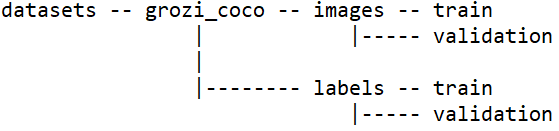




In [43]:
#The following function will generate the data directories splited into train, val, test.
from pathlib import Path

def create_data_directories(data_name):
    Path(f"../drive/Shareddrives/Code Challenges/Memorable/{data_name}/labels/train2017").mkdir(parents=True, exist_ok=True)
    Path(f"../drive/Shareddrives/Code Challenges/Memorable/{data_name}/labels/val2017").mkdir(parents=True, exist_ok=True)
    
create_data_directories('grozi_coco')

In [44]:
labels_path = dir_to_project+'/grozi_coco/labels/'

Extract the annotations files (train,val) to labels folders with the YOLOv5 format

In [45]:
training_yolo_label = os.path.isdir(labels_path+'train2017')
val_yolo_label = os.path.isdir(labels_path+'val2017')

In [46]:
#check if the labels were already created
if training_yolo_label == False:
  ConvertCOCOToYOLO(label_path=labels_path+'train2017',json_path=annFile).convert()
else:
  print('Labels for training already created')

Labels for training already created


In [47]:
annFile_val = '{}/annotations/instances_{}.json'.format(dataDir,dataType[1])

In [48]:
if training_yolo_label == False:
  ConvertCOCOToYOLO(label_path=labels_path+'val2017',json_path=annFile_val).convert()
else:
  print('Labels for validating already created')

Labels for validating already created


# Training and *Validation* of the model




In [49]:
#See how many files we have in the training and validation dataset (so it can be taken into account wheather the model is trained)
#from scratch or using the pretrained model with its weights

#Get the directory where the images of the training dataset are stored
%cd /content/drive/Shareddrives/Code Challenges/Memorable/grozi_coco/images/train2017

#Get how many images are in the training dataset
train_quantity = len(os.listdir())
print('\n' ,f'The number of images to train the model is: {train_quantity} images','\n' )

#Get the directory where the images of the test dataset are stored
%cd /content/drive/Shareddrives/Code Challenges/Memorable/grozi_coco/images/val2017

#Get how many images are in the test dataset
validation_quantity = len(os.listdir())
print('\n' ,f'The number of images to validate the model is: {validation_quantity} images')

#get the percentage of train / test split
train_percentage = round(train_quantity / (train_quantity + validation_quantity),2)*100
print('\n' ,f'The percentage of train/validation split is {train_percentage}/{100-train_percentage} %')

/content/drive/Shareddrives/Code Challenges/Memorable/grozi_coco/images/train2017

 The number of images to train the model is: 596 images 

/content/drive/Shareddrives/Code Challenges/Memorable/grozi_coco/images/val2017

 The number of images to validate the model is: 85 images

 The percentage of train/validation split is 88.0/12.0 %


#### Configuration files

The **data-configurations** file describes the dataset parameters. Since we are training on our custom dataset, we will edit this file and provide: 

- the paths to the train, validation and test (optional) datasets; 
- the number of classes (nc); 
- and the names of the classes in the same order as their index. 

We named our custom data configurations file as ‘grocery_data.yaml’ and placed it under the ‘data’ directory from the yolov5 repo. 

The content of this YAML file is as follow:

In [50]:
# #define the parameters for the DATA configuration file (file_name.yaml)
yaml_content = '''

train: /content/drive/Shareddrives/Code Challenges/Memorable/grozi_coco/images/train2017
val: /content/drive/Shareddrives/Code Challenges/Memorable/grozi_coco/images/val2017

nc: '''+ str(number_of_classes) +'''     #Number of classes 

names: '''+ str(classes_names)+'''   #Classes names

'''


In [51]:
#used this YAML validator as it was throwing back error:
# https://codebeautify.org/yaml-validator

In [52]:
print(yaml_content)



train: /content/drive/Shareddrives/Code Challenges/Memorable/grozi_coco/images/train2017
val: /content/drive/Shareddrives/Code Challenges/Memorable/grozi_coco/images/val2017

nc: 1063     #Number of classes 

names: ['0.jpg', '1.jpg', '2.jpg', '3.jpg', '4.jpg', '5.jpg', '6.jpg', '7.jpg', '8.jpg', '9.jpg', '10.jpg', '11.jpg', '413.jpg', '13.jpg', '14.jpg', '15.jpg', '16.jpg', '17.jpg', '18.jpg', '19.jpg', '20.jpg', '21.jpg', '1001.jpg', '22.jpg', '23.jpg', '28.jpg', '29.jpg', '26.jpg', '27.jpg', '31.jpg', '32.jpg', '33.jpg', '1221.jpg', '35.jpg', '36.jpg', '37.jpg', '34.jpg', '38.jpg', '39.jpg', '1218.jpg', '41.jpg', '42.jpg', '43.jpg', '44.jpg', '45.jpg', '46.jpg', '54.jpg', '47.jpg', '48.jpg', '49.jpg', '50.jpg', '56.jpg', '52.jpg', '53.jpg', '55.jpg', '51.jpg', '57.jpg', '58.jpg', '59.jpg', '60.jpg', '61.jpg', '62.jpg', '63.jpg', '67.jpg', '68.jpg', '69.jpg', '70.jpg', '71.jpg', '72.jpg', '73.jpg', '74.jpg', '75.jpg', '76.jpg', '77.jpg', '78.jpg', '79.jpg', '599.jpg', '81.jpg', '60

In [53]:
# Write the yaml_content to a file

with open(dir_to_repo+'/data/grocery_data.yaml', 'w') as writefile:
    writefile.write(yaml_content)

2. The **model-configurations file** dictates the model architecture. 

Ultralytics supports several YOLOv5 architectures, named P5 models, which varies mainly by their parameters size: YOLOv5n (nano), YOLOv5s (small), YOLOv5m (medium), YOLOv5s (large), YOLOv5x (extra large). 

These architecture are suitable for training with image size of 640*640 pixels. Additional series, that is optimized for training with larger image size of 1280*1280, called P6 (YOLOv5n6, YOLOv5s6, YOLOv5m6, YOLOv5l6, YOLOv5x6). P6 models include an extra output layer for detection of larger objects. They benefit the most from training at higher resolution, and produce better results.

Ultralytics provides build-in, model-configuration files for each of the above architectures, placed under the ‘models’ directory. 

If we're training from scratch, we would choose the model-configurations YAML file with the desired architecture (‘YOLOv5n.yaml’ in this tutorial), and just edit the number of classes (nc) parameter to the correct number of classes in your custom data.

When training is initialized from pre-trained weights as we are doing, no need to edit the model-configurations file since the model will be extracted with the pretrained weights.

In [54]:
#---------------------------------------------------------------------------------------------------

3. The **hyperparameters-configurations file** defines the hyperparameters for the training, including the learning rate, momentum, losses, augmentations etc. Ultralytics provides a default hyperparameters file under the ‘data/hyp/hyp.scratch.yaml’ directory. 

As it is mostly recommended to start training with default hyperparameters to establish a performance baseline, we won't edit the file.

In [ ]:
#---------------------------------------------------------------------------------------------------

#### Transfer Learning
To achieve a robust YOLOv5 model, it is recommended to train with over 1500 images per class, and more then 10,000 instances per class. It is also recommended to add up to 10% background images, to reduce false-positives errors. Since my dataset is significantly small, I will narrow the training process using transfer learning technics.

Since the grozi coco dataset is relatively small (~560 images), transfer learning is expected to produce better results than training from scratch.

Our model will be initialize with weights from a pre-trained model, by passing the name of the model to the ‘weights’ argument. The pre-trained model will be automatically download.

We will start with the YOLOv5 nano model and use its training in order to then train the YOLOv5s model. When you go further up into the YOLOv5 family the accuracy tends to improve

### First Run

- Batch = 10
- Epochs = 100
- Weights = pretrained Yolov5 nano on COCO dataset
- model = Yolov5 nano

In [ ]:
!python /content/yolov5/train.py --batch 10 --epochs 100 --data {dir_to_repo}/data/grocery_data.yaml --weights 'yolov5n.pt' --cfg {dir_to_repo}/models/yolov5n.yaml' --cache

train: weights=yolov5n.pt, cfg=/content/yolov5/models/yolov5n.yaml, data=/content/yolov5/data/grocery_data.yaml, hyp=../data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=10, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=../runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.1-74-gcf4f3c3 torch 1.10.0+cu111 CUDA:0 (Tesla K80, 11441MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_

#### Validation

To better understand the results, let’s summarize YOLOv5 losses and metrics. YOLO loss function is composed of three parts:

1. box_loss — bounding box regression loss (Mean Squared Error).
2. obj_loss — the confidence of object presence is the objectness loss (Binary Cross Entropy).
3. cls_loss — the classification loss (Cross Entropy).
4. **Precision** measures how much of the bbox predictions are correct ( True positives / (True positives + False positives))
5. **Recall** measures how much of the true bbox were correctly predicted ( True positives / (True positives + False negatives))
6. ‘mAP_0.5’ is the mean Average Precision (mAP) at IoU (Intersection over Union) threshold of 0.5. 
7. ‘ mAP_0.5:0.95’ is the average mAP over different IoU thresholds, ranging from 0.5 to 0.95.


(-0.5, 2399.5, 1199.5, -0.5)

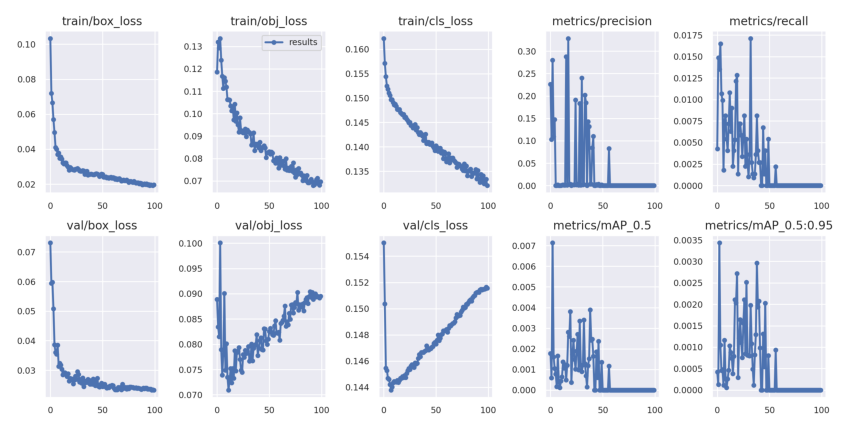

In [68]:
# load and display image
results = io.imread(dir_to_project+'/yolov5/runs/train/exp/results.png')
fig, ax = plt.subplots(figsize=(15, 16))
ax.imshow(results);plt.axis('off')

- Classification loss: Cross-entropy loss, or log loss, measures the erformance of a classification model whose output is a probability value between 0 and 1. Cross-entropy loss increases as the predicted probability diverges from the actual label. So we can see that with more epochs the ability to classificate increases.
- Precision and Recall: We have some true positive cases but as we advanced on the epochs, the model stops being able to detect well.

>From the metrics we could suppose that the model is underfitting as it does not perform well with either dataset (training and validation)


After each training we will be exporting the weights of the model so that we can keep training from the last "checkpoint" of last model, taking advantage of the transfer learning technique

In [82]:
from google.colab import files

In [ ]:
files.download(dir_to_repo+'/runs/train/exp/weights/best.pt')
files.download(dir_to_repo+'/runs/train/exp/weights/last.pt')

### Second Run

- Batch = 16
- Epochs = 150
- Weights = weights from previous run
- model = Yolov5 nano

Based on the training of the last model, we will use its parameters to train again the model

In [ ]:
!python /content/yolov5/train.py --batch 16 --epochs 150 --data {dir_to_repo}/data/grocery_data.yaml --weights {dir_to_repo}/runs/train/exp/weights/best.pt --cfg {dir_to_repo}/models/yolov5n.yaml --cache

train: weights=/content/yolov5/best.pt, cfg=/content/yolov5/models/yolov5n.yaml, data=/content/yolov5/data/grocery_data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=150, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.1-74-gcf4f3c3 torch 1.10.0+cu111 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0

#### Validation

(-0.5, 2399.5, 1199.5, -0.5)

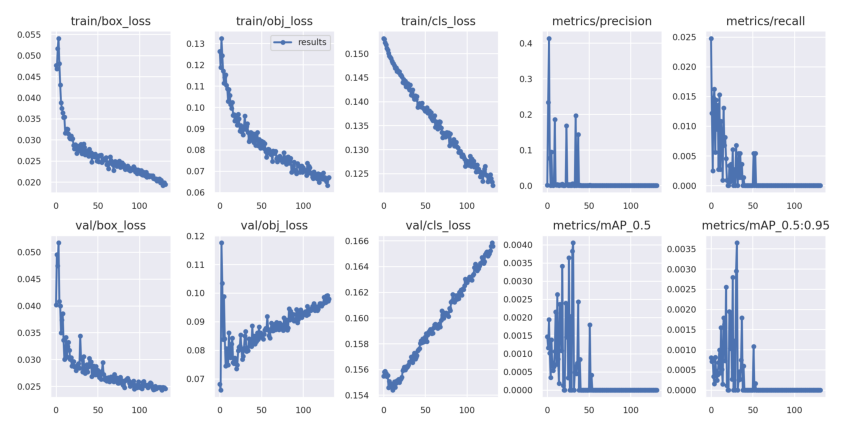

In [69]:
# load and display image
results = io.imread(dir_to_project+'/yolov5/runs/train/exp2/results.png')
fig, ax = plt.subplots(figsize=(15, 16))
ax.imshow(results);plt.axis('off')

- The Precision and Recall had an increase with a better score after using the pretrained weights from the past run.
- The MAP metrics remained low

In [ ]:
files.download(dir_to_repo+'/runs/train/exp2/weights/best.pt')
files.download(dir_to_repo+'/runs/train/exp2/weights/last.pt')

### Third Run

- Batch = 8
- Epochs = 200
- Weights = weights from previous run
- model = Yolov5 small

The training was stop early as there was no improvement in the last 100 epochs. The best results were observed at epoch 31. We will continue the training with the next model in size of the YOLOv5 family >> YOLOv5s.

In [ ]:
!python /content/yolov5/train.py --batch 8 --epochs 200 --data {dir_to_repo}/data/grocery_data.yaml --weights {dir_to_repo}/runs/train/exp2/weights/best.pt --cfg {dir_to_repo}/models/yolov5s.yaml --cache

train: weights=/content/yolov5/runs/train/exp2/weights/best.pt, cfg=/content/yolov5/models/yolov5s.yaml, data=/content/yolov5/data/grocery_data.yaml, hyp=../../../../../../../yolov5/data/hyps/hyp.scratch-low.yaml, epochs=200, batch_size=8, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=../../../../../../../yolov5/runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.1-75-g9c1e91a torch 1.10.0+cu111 CUDA:0 (Tesla K80, 11441MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05,

In [ ]:
files.download(dir_to_repo+'/runs/train/exp3/weights/best.pt')
files.download(dir_to_repo+'/runs/train/exp3/weights/last.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Logs on the runs

We can see for example how the input for the training data was consumed

(-0.5, 1919.5, 1919.5, -0.5)

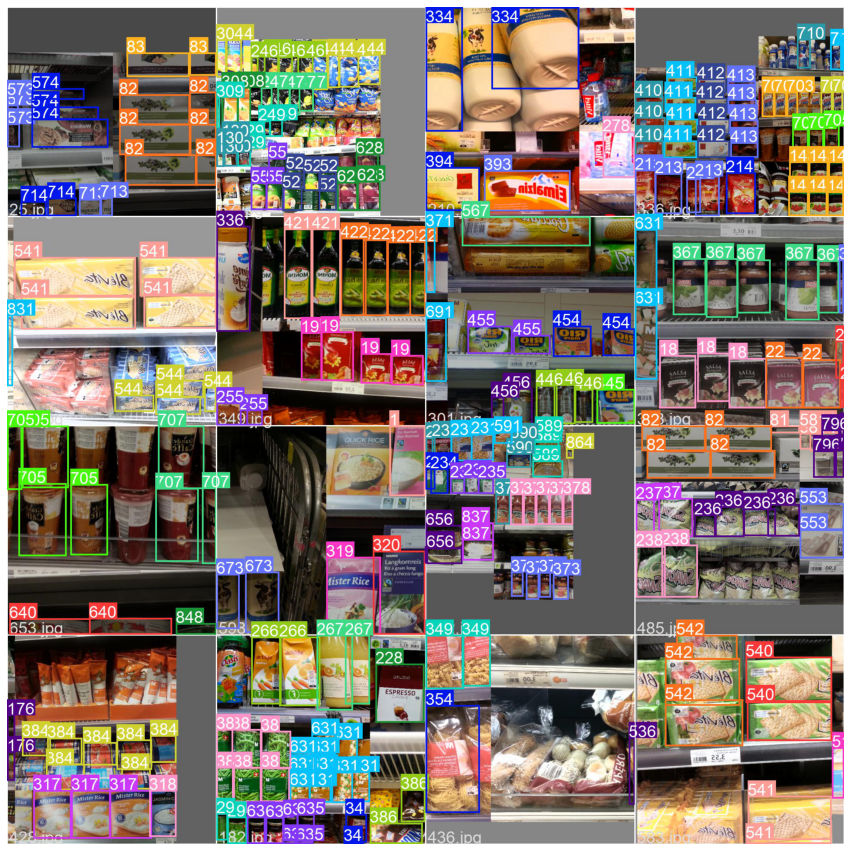

In [78]:
train_batch2 = io.imread(dir_to_repo+'/runs/train/exp/train_batch0.jpg')
fig, ax = plt.subplots(figsize=(15, 16))
ax.imshow(train_batch2);plt.axis('off')

`val_batch2_labels.jpg` shows the labels for validating the algorithm:

(-0.5, 1463.5, 1919.5, -0.5)

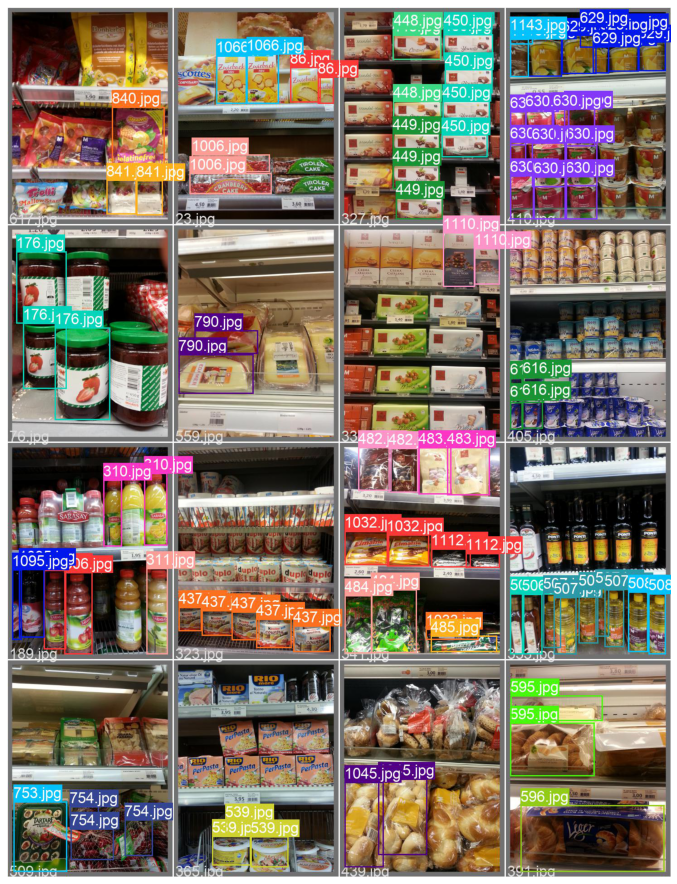

In [79]:
val_batch2 = io.imread(dir_to_repo+'/runs/train/exp/train_batch0.jpg')
fig, ax = plt.subplots(figsize=(15, 16))
ax.imshow(val_batch2);plt.axis('off')

`val_batch2_pred.jpg` shows the labels for validating the algorithm:

(-0.5, 1463.5, 1919.5, -0.5)

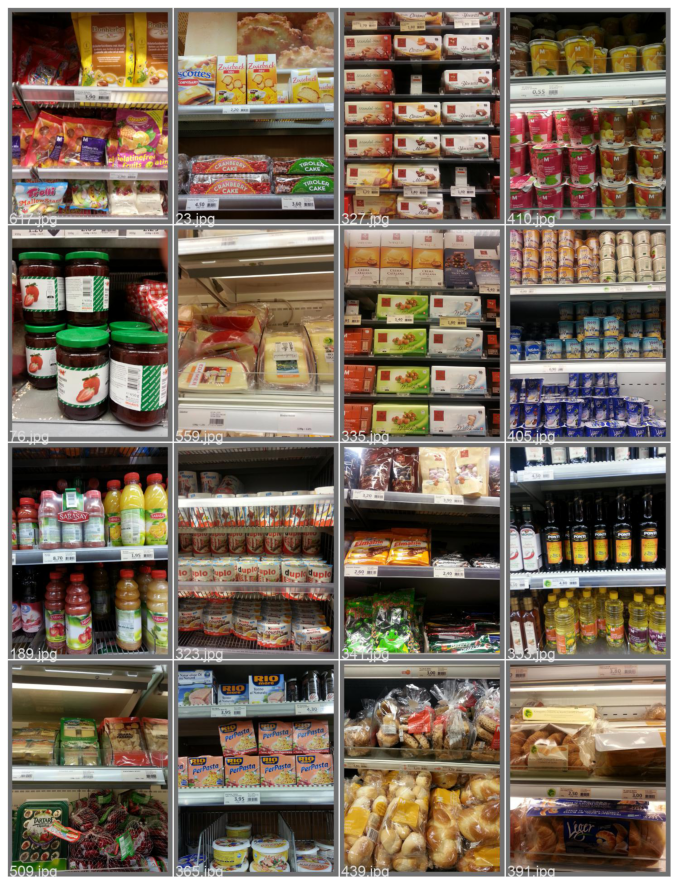

In [80]:
val_batch2_pred = io.imread(dir_to_repo+'/runs/train/exp/train_batch0.jpg')
fig, ax = plt.subplots(figsize=(15, 16))
ax.imshow(val_batch2_pred);plt.axis('off')

Unfortunately, the result of the training ended with a model uncapable of detecting objects. For next steps and other approaches, go to the "Considerations" section.

# Exporting Results

In [ ]:
from google.colab import files
import os

dir_to_zip = '/content/yolov5/runs' #@param {type: "string"}
output_filename = 'yolov5_runs.zip' #@param {type: "string"}
delete_dir_after_download = "No"  #@param ['Yes', 'No']

os.system( "zip -r {} {}".format( output_filename , dir_to_zip ) )

if delete_dir_after_download == "Yes":
    os.system( "rm -r {}".format( dir_to_zip ) )

files.download( output_filename )

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Inference

Run inference on any image or set of images

In [102]:
#/content/yolov5/runs/train/exp3/weights/best.pt

%cd
dir_to_img = files.upload()
!python /content/yolov5/detect.py --weights {dir_to_project}/grozi_coco/weights/exp3/best.pt --img 640 --source {dir_to_img}

# val_batch2_pred = io.imread('runs/detect/exp/')
# fig, ax = plt.subplots(figsize=(15, 16))
# ax.imshow(val_batch2_pred);plt.axis('off')

/root
detect: weights=['/content/drive/Shareddrives/Code Challenges/Memorable/grozi_coco/weights/exp3/best.pt'], source=/content/drive/Shareddrives/Code Challenges/Memorable/grozi_coco/images/val2017/126.jpg, data=../content/yolov5/data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=../content/yolov5/runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.1-76-gc94736a torch 1.10.0+cu111 CUDA:0 (Tesla K80, 11441MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 9877036 parameters, 0 gradients, 25.0 GFLOPs
image 1/1 /content/drive/Shareddrives/Code Challenges/Memorable/grozi_coco/images/val2017/126.jpg: 480x640 Done. (0.051s)
Speed: 0.6ms pre-process, 51.4ms inference, 1.7ms NMS per image at shape (1, 3, 640, 

(-0.5, 3263.5, 2447.5, -0.5)

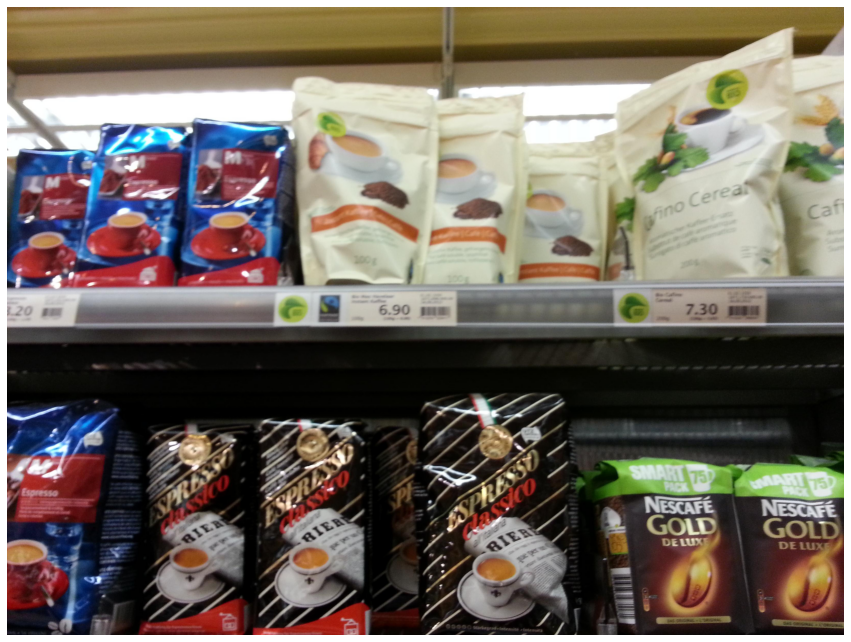

In [104]:
inference_img = io.imread(dir_to_repo+'/runs/detect/exp3/126.jpg')
fig, ax = plt.subplots(figsize=(15, 16))
ax.imshow(inference_img);plt.axis('off')

# Final comments and Considerations

Unfortunately, the model was not able to sucessfully detect objects. We were able to see this in the metrics as well as in the actual inference of the model. 

Some potential next steps for better training and performance of the model:

- When using GPU, the model encountered on frequent ocassion  when training with OUT OF MEMORY errors, so the batch size or epochs had to be diminished sacrificing potencial accuracy/quality of the model. For sorting this out there a few tricks, as for example using **Gradient Accumulation** or **Training with AMP (Automatic Mixed Precision)**, for more details click on the [link](https://towardsdatascience.com/i-am-so-done-with-cuda-out-of-memory-c62f42947dca)

- Adjusting the code so that TPUs can be used so that better hyperparameters can be selected (as a higher batch size or more epochs). 

- Another approach would be: Training the model from scratch on a dataset with a related topic, as for example it would be with the [SKU-110 K](https://https://github.com/eg4000/SKU110K_CVPR19) dataset. After training, using the weights, re train the model for our custom grozi coco dataset. 

- When using the pretrained weights of the SKU-110K training, making use of the technique of [feature extraction](https://(https://github.com/ultralytics/yolov5/issues/1314). So to further compensate for a small dataset size, we would use the same backbone as the pretrained model, and only train the model’s head

- Beginning with a simpler model and post processing  in order to get a faster and better grasp. How? Reducing the input image size, dropping classes that did not have so many instances, etc.




# Bibliography

- Maindola, G., 2022. Introduction to YOLOv5 Object Detection with Tutorial - MLK - Machine Learning Knowledge. [online] Machinelearningknowledge.ai. Available at: <https://machinelearningknowledge.ai/introduction-to-yolov5-object-detection-with-tutorial/> [Accessed 21 June 2021].

- Gandhi, R., 2018. R-CNN, Fast R-CNN, Faster R-CNN, YOLO — Object Detection Algorithms. [online] Medium. Available at: <https://towardsdatascience.com/r-cnn-fast-r-cnn-faster-r-cnn-yolo-object-detection-algorithms-36d53571365e> [Accessed 9 July 2018].

- Gur Arie, L., 2022. The practical guide for Object Detection with YOLOv5 algorithm. [online] Medium. Available at: <https://towardsdatascience.com/the-practical-guide-for-object-detection-with-yolov5-algorithm-74c04aac4843> [Accessed 14 March 2022].

- Cochard, D., 2021. YOLOv5 : The Latest Model for Object Detection. [online] Medium. Available at: <https://medium.com/axinc-ai/yolov5-the-latest-model-for-object-detection-b13320ec516b> [Accessed 29 March 2021].

- Yohanandan, S., 2020. mAP (mean Average Precision) might confuse you!. [online] Medium. Available at: <https://towardsdatascience.com/map-mean-average-precision-might-confuse-you-5956f1bfa9e2> [Accessed 9 June 2020].
